### 1. Data Loading & Initialization
### Purpose:

Installs and loads Seurat and dependencies for single-cell RNA-seq analysis.

Reads raw gene expression data (pancreas_counts.csv) and a cell metadata (metadata_FACS.csv).

In [14]:
install.packages("Seurat")
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)


Warning message:
"package 'Seurat' is in use and will not be installed"


In [4]:
# 1. Data Loading & Initialization -------------------------------------------
# Load raw count data and metadata directly from CSV files
raw_counts <- read.csv("C:\\Users\\Ermias\\Documents\\data visualization\\scRNA.file\\FACS\\pancreas_counts.csv", row.names = 1)

metadata <- read.csv("C:\\Users\\Ermias\\Desktop\\seurat.project\\scRNA.file\\metadata_FACS.csv", row.names = 1)

# Convert raw_counts to a matrix (if it's a data frame)
raw_counts <- as.matrix(raw_counts)

# Optionally, ensure no underscores in feature names
rownames(raw_counts) <- gsub("_", "-", rownames(raw_counts))

# Create Seurat object
pancreas <- CreateSeuratObject(counts = raw_counts, 
                               project = "pancreas_study", 
                               min.cells = 3, 
                               min.features = 200) 

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [32]:
# Check the length of both
length(rownames(metadata))
length(colnames(pancreas))
str(metadata)
# Assuming the column to be used as row names is "cell_id" (replace with actual column name)
rownames(metadata) <- metadata$cell_id
metadata$cell_id <- NULL  # Optionally remove this column if it's no longer needed
# Check if row names of metadata match column names of Seurat object
identical(rownames(metadata), colnames(pancreas))
# Reorder metadata by matching cell identifiers with Seurat object column names
metadata <- metadata[match(colnames(pancreas), metadata$cell_id), ]
rownames(metadata) <- colnames(pancreas)


[1] 1872

[1] 527

'data.frame':	1872 obs. of  5 variables:
 $ mouse.id      : chr  NA NA NA NA ...
 $ tissue        : chr  NA NA NA NA ...
 $ subtissue     : chr  NA NA NA NA ...
 $ FACS.selection: chr  NA NA NA NA ...
 $ mouse.sex     : chr  NA NA NA NA ...


[1] FALSE

In [6]:
# Add metadata to Seurat object
pancreas<- AddMetaData(pancreas, metadata = metadata)

# Select tissue with 2 or more sub-tissues
# Adjust path to your specific data
head(pancreas@meta.data)
selected_tissue <- pancreas@meta.data %>% filter(!is.na(subtissue) & subtissue >= 2)


,orig.ident,nCount_RNA,nFeature_RNA,mouse.id,tissue,subtissue,FACS.selection,mouse.sex
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
B21.MAA000574.3_8_M.1.1,pancreas_study,4932310,2854,NA,NA,NA,NA,NA
D12.MAA000574.3_8_M.1.1,pancreas_study,1139900,346,NA,NA,NA,NA,NA
B22.MAA000574.3_8_M.1.1,pancreas_study,5790505,2521,NA,NA,NA,NA,NA
D13.MAA000574.3_8_M.1.1,pancreas_study,1986467,4166,NA,NA,NA,NA,NA
C1.MAA000574.3_8_M.1.1,pancreas_study,525766,229,NA,NA,NA,NA,NA
D14.MAA000574.3_8_M.1.1,pancreas_study,1285236,1477,NA,NA,NA,NA,NA


### 2. Quality Control (QC)
### Purpose:

Identifies cells with high mitochondrial gene content (indicates apoptosis or stress).

Filters cells with too few/many genes or high mitochondrial content.

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


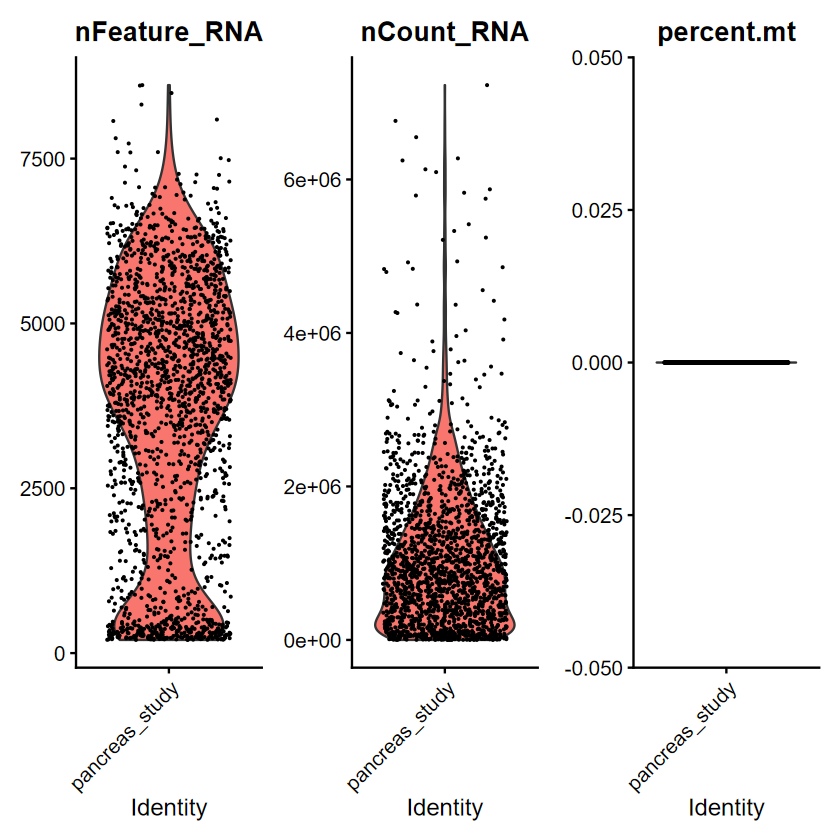

In [8]:
### 2. Quality Control Metrics -------------------------------------------------
pancreas[["percent.mt"]] <- PercentageFeatureSet(pancreas, pattern = "^MT-")

# Visual QC metrics
VlnPlot(pancreas, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"


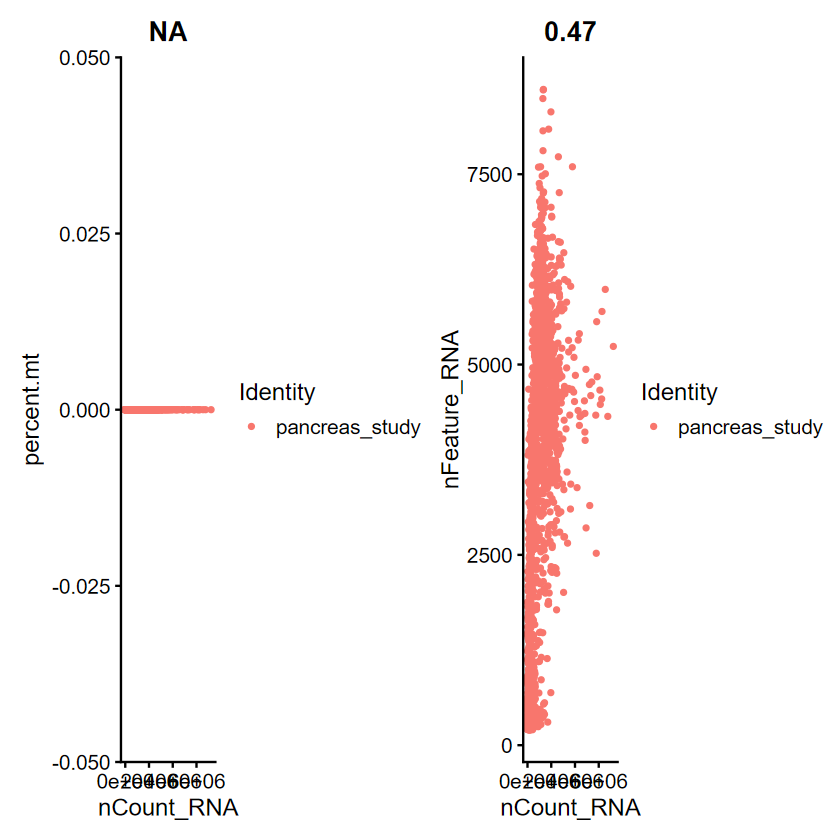

In [10]:
# Feature correlation plots
plot1 <- FeatureScatter(pancreas, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pancreas, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

# Filter based on QC metrics
pancreas <- subset(pancreas, subset = nFeature_RNA > 200 & 
                     nFeature_RNA < 2500 & 
                     percent.mt < 5)

In [33]:
### 3. Data Processing ---------------------------------------------------------
# Create the plot using the cleaned data
load("clean_data.RData")  # If saved previously

plot1 <- ggplot(clean_data, aes(x = nCount_RNA, y = nFeature_RNA)) + 
  geom_point() +
  scale_x_log10(labels = scales::comma, limits = c(1, NA)) +
  theme_minimal()

plot2 <- ggplot(clean_data, aes(x = nCount_RNA, y = nFeature_RNA)) + 
  geom_point() +
  scale_x_log10(labels = scales::comma, limits = c(1, NA)) +
  theme_minimal()

# Combine the plots
plot1 + plot2

Warning message in readChar(con, 5L, useBytes = TRUE):
"cannot open compressed file 'clean_data.RData', probable reason 'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [ ]:
# Correcting the warning by using `layer`
data_matrix <- GetAssayData(pancreas, layer = "data")

# Filtering out non-positive values
positive_data <- data_matrix[data_matrix > 0]

# Applying log-10 transformation
log_transformed_data <- log10(positive_data)
log_transformed_df <- as.data.frame(log_transformed_data)
colnames(log_transformed_df) <- c("value")

plot1 <- ggplot(log_transformed_df, aes(x = 1:nrow(log_transformed_df), y = value)) + 
  geom_point() + 
  scale_x_log10()

plot2 <- ggplot(log_transformed_df, aes(x = 1:nrow(log_transformed_df), y = value)) + 
  geom_line() + 
  scale_x_log10()
combined_plot <- plot1 + plot2
combined_plot